"""
This script is used to analyze data and produce Figure 3 of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import seaborn as sns
from scipy import interpolate

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
rootDir="/content/drive/MyDrive/SYNC_Projects/"

rootDir=rootDir+"pBGT/GIT/"

data_path=rootDir+"data/LB-AMP-LB/"
data_pathD=rootDir+"data/Figure_3/"

fig_path=rootDir+"figures/"

In [4]:

#dataPath = Path(data_path) / 'LB-AMP-LB/'

pfileName0 = data_path+'pBGT_LB-AMP-LB_AMNIS_reread.csv'
pfileName =data_path+ 'pBGT_LB-AMP-LB_AMNIS.csv'
cfileName =data_path+ 'MGGT_LB-AMP-LB_AMNIS.csv'

dataP0 = pd.read_csv(pfileName0, sep='\t')
display(dataP0.head(2))
dataP = pd.read_csv(pfileName, sep='\t')
display(dataP.head(2))
dataC = pd.read_csv(cfileName, sep='\t')
display(dataC.head(2))

,Object Number,Area_M01,Area_M02,Area_M04,Aspect Ratio_M01,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M01_Ch01,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,Intensity_MC_Ch02,strain,season,treatment,replicate,dose number
0,0,5.111111,12.888889,7.888889,0.587880,0.654149,0.703282,36.155203,39.145853,37.481128,18949.927419,pBGT,1,LB,rep-1,2
1,1,4.888889,10.555556,6.000000,0.802697,0.836098,0.756472,44.959663,46.114739,45.835153,23263.274194,pBGT,1,LB,rep-1,2


,Object Number,Area_M01,Area_M02,Area_M04,Aspect Ratio_M01,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M01_Ch01,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,Intensity_MC_Ch02,strain,season,treatment,replicate,dose number
0,0,3.666667,7.777778,4.333333,0.718028,0.791963,0.787808,42.379388,44.115431,46.022834,12642.50000,pBGT,1,LB,rep-1,2
1,1,4.333333,10.000000,5.666667,0.787808,0.826160,0.838422,40.785294,42.450941,42.158897,17923.28629,pBGT,1,LB,rep-1,2


,Object Number,Area_M01,Area_M02,Area_M04,Aspect Ratio_M01,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M01_Ch01,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,Intensity_MC_Ch02,strain,season,treatment,replicate,dose number
0,0,0.0,55.222222,0.0,0.0,0.502838,0.0,0.0,20.293874,0.0,3574.465116,MGGT,1,LB,rep-1,2
1,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,43.690217,MGGT,1,LB,rep-1,2


In [5]:
numDays = 3
nreps = 3

colsP = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
AsP = [0, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
strAsP = ['AMP=0', '1/256 MIC', '1/128 MIC', '1/64 MIC', '1/32 MIC', '1/16 MIC', '1/8 MIC', '1/4 MIC', '1/2 MIC', 'MIC']

colsC = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
AsC = [0, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
strAsC = ['AMP=0', '1/128 MIC', '1/64 MIC', '1/32 MIC', '1/16 MIC', '1/8 MIC', '1/4 MIC', '1/2 MIC', 'MIC']


treatments=['Season 1: LB', 'Season 2: LB+AMP','Season 3: LB']


## Fig 3A

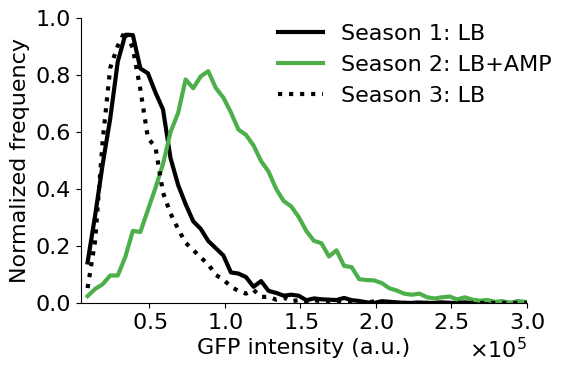

In [9]:

lim_aspect=[.2, 1];
lim_area=[25, 35];
xmax=0.75e6;
xmin=0.9e4;
xdelta=0.5e4;
col=[0.3020, 0.6863 , 0.2902]



meanGFPsP=np.zeros((numDays, len(AsP), nreps))

st=['-','-',':']
stcol=['k',col,'k']
xs_range=np.arange(xmin,xmax,xdelta)
iA=8;  #Plasmid


fig,ax=plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size': 16})
fig.set_facecolor('white')

for day in range(numDays):
    if day == 0:
        this_df = dataP0
    else:
        this_df = dataP

    dayData = this_df[(this_df["season"] == day+1) & (this_df["dose number"] == colsP[iA])]

    repH = []
    meanGFP = np.zeros(nreps)
    for irep in range(nreps):

        repname = f"rep-{irep+1}"
        repData = dayData[dayData.replicate == repname]
        thisGFP = repData.Intensity_MC_Ch02[(repData.Area_M02 > lim_area[0]) &
                                              (repData.Area_M02 < lim_area[1]) &
                                              (repData["Aspect Ratio_M02"] > lim_aspect[0]) &
                                              (repData["Aspect Ratio_M02"] < lim_aspect[1])
                                              ]
        #print(day,len(thisGFP))
        h, xb = np.histogram(thisGFP[(thisGFP > xmin) & (thisGFP < xmax)], bins=xs_range)
        hnorm = h / np.max(h)

        meanGFP[irep] = np.mean(thisGFP)
        repH.append(hnorm)

    plt.plot(xs_range[:-1], np.mean(repH, axis=0), ls=st[day], linewidth=3, color=stcol[day],label=treatments[day])
    #plt.plot(meanGFP, ls=st[day], linewidth=3, color=stcol[day])



xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .
plt.gca().xaxis.set_major_formatter(xfmt)

ax.spines[['right', 'top']].set_visible(False)
plt.axis([xmin*0.5, xmax*0.4, 0, 1])
ax.xaxis.major.formatter._useMathText = True
#xticks=ax.get_xticks()
#print(xticks)
#xtickslables=[0,"0.5x10$^5$","1x10$^5$","1.5$x10^5$","2x10$^5$","2.5x10$^5$","3x10$^5$"]
#plt.xticks(xticks,xtickslables)
plt.ylabel("Normalized frequency")
plt.xlabel("GFP intensity (a.u.)")

plt.legend(frameon=False,bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
figname=fig_path+"Fig-3A.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


## Fig 3B

/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-3B.pdf


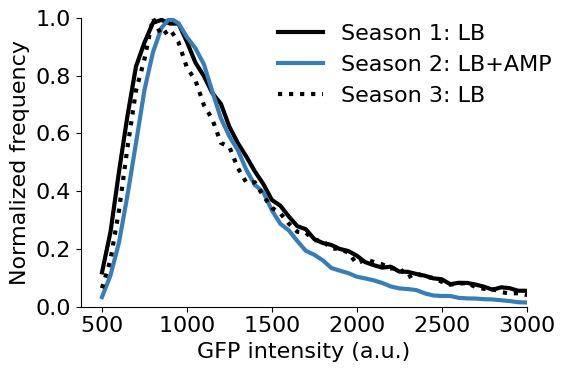

In [11]:

lim_aspect=[.2, 1];
lim_area=[1, 35];
xmax=7.5e3;
xmin=5e2;
xdelta=.5e2;
col=[0.2157, 0.4941, 0.7216];



meanGFPsP=np.zeros((numDays, len(AsP), nreps))
treatments=['Season 1: LB', 'Season 2: LB+AMP','Season 3: LB']

st=['-','-',':']
stcol=['k',col,'k']
xs_range=np.arange(xmin,xmax,xdelta)
iA=8;  #Plasmid


#fig=plt.figure(figsize=(6,4))
fig,ax=plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size': 16})
fig.set_facecolor('white')
#plt.axis("off")
for day in range(numDays):
    this_df = dataC

    dayData = this_df[(this_df["season"] == day+1) & (this_df["dose number"] == colsP[iA])]

    repH = []
    meanGFP = np.zeros(nreps)
    for irep in range(nreps):

        repname = f"rep-{irep+1}"
        repData = dayData[dayData.replicate == repname]
        thisGFP = repData.Intensity_MC_Ch02[(repData.Area_M02 > lim_area[0]) &
                                              (repData.Area_M02 < lim_area[1]) &
                                              (repData["Aspect Ratio_M02"] > lim_aspect[0]) &
                                              (repData["Aspect Ratio_M02"] < lim_aspect[1])
                                              ]
        ngfps=len(thisGFP)
        if(ngfps<1000):
            continue
        #print(day,ngfps)
        h, xb = np.histogram(thisGFP[(thisGFP > xmin) & (thisGFP < xmax)], bins=xs_range)
        hnorm = h / np.max(h)

        meanGFP[irep] = np.mean(thisGFP)
        repH.append(hnorm)

    plt.plot(xs_range[:-1], np.mean(repH, axis=0), ls=st[day], linewidth=3, color=stcol[day],label=treatments[day])

#xfmt = ScalarFormatter()
#xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .
#plt.gca().xaxis.set_major_formatter(xfmt)
ax.spines[['right', 'top']].set_visible(False)
plt.axis([xmin*0.75, xmax*0.4, 0, 1])
ax.xaxis.major.formatter._useMathText = True
plt.ylabel("Normalized frequency")
plt.xlabel("GFP intensity (a.u.)")

plt.legend(frameon=False,bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
figname=fig_path+"Fig-3B.pdf"
print(figname)
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


## Fig 3C

In [12]:


meanGFPsP=np.zeros((numDays, len(AsP), nreps))
lim_aspect=[.2, 1];
lim_area=[25, 35];
#cvGFPs=zeros(numDays, length(As), length(reps));


for day in range(numDays):
    if day == 0:
        this_df = dataP0
    else:
        this_df = dataP

    dayData = this_df[this_df["season"] == day+1 ]

    for iA in range(len(AsP)):
        dayAsData=dayData[dayData["dose number"]==colsP[iA]];
        for irep in range(nreps):
            repname=f"rep-{irep+1}"
            asrepData=dayAsData[dayAsData.replicate==repname]
            thisGFP=asrepData.Intensity_MC_Ch02[(asrepData.Area_M02 > lim_area[0]) &
                                              (asrepData.Area_M02 < lim_area[1]) &
                                              (asrepData["Aspect Ratio_M02"] > lim_aspect[0]) &
                                              (asrepData["Aspect Ratio_M02"] < lim_aspect[1])
                                            ]
            meanGFPsP[day, iA, irep]=np.mean(thisGFP);
            #cvGFPs(day, iA, irep]=getCV(thisGFP);
            #stdGFPs(day, iA, irep)=std(thisGFP);


#display(meanGFPsP)

######################### MGGT
meanGFPsC=np.zeros((numDays, len(AsC), nreps))
lim_aspect=[.2, 1];
lim_area=[1, 35];
# cvGFPs=zeros(numDays, length(As), length(reps));

this_df = dataC
for day in range(numDays):

    dayData = this_df[this_df["season"] == day+1 ]

    for iA in range(len(AsC)):
        dayAsData=dayData[dayData["dose number"]==colsC[iA]]
        for irep in range(nreps):
            repname=f"rep-{irep+1}"
            asrepData=dayAsData[dayAsData.replicate==repname]
            thisGFP=asrepData.Intensity_MC_Ch02[(asrepData.Area_M02 > lim_area[0]) &
                                              (asrepData.Area_M02 < lim_area[1]) &
                                              (asrepData["Aspect Ratio_M02"] > lim_aspect[0]) &
                                              (asrepData["Aspect Ratio_M02"] < lim_aspect[1])
                                            ]
            if(len(thisGFP)>1000):
                meanGFPsC[day, iA, irep]=np.mean(thisGFP);
#             %cvGFPs(day, iA, irep)=getCV(thisGFP);
#             %stdGFPs(day, iA, irep)=std(thisGFP);
#display(meanGFPsC)

['sans-serif']


<ipython-input-19-bec4b778ba97>:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(s_mp,shrink=.95,fraction=.1,pad=.025)


/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-3C.pdf


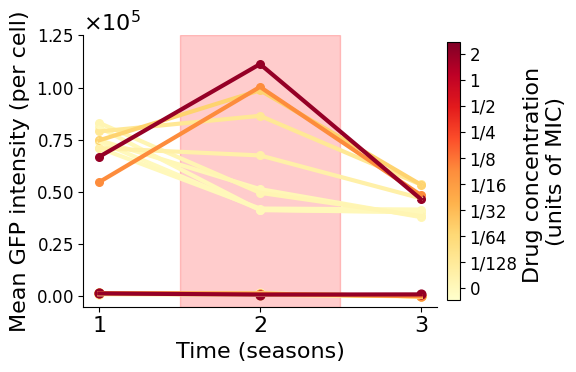

In [19]:
fig,ax=plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size': 16})
fig.set_facecolor('white')
fontfam=plt.rcParams["font.family"]
print(fontfam)


c_m = matplotlib.cm.YlOrRd
normp = matplotlib.colors.Normalize(vmin=np.min(AsP)-.05,vmax=np.max(AsP)+.05)
s_mp = matplotlib.cm.ScalarMappable(cmap=c_m, norm=normp)
s_mp.set_array([])

for iA in range(len(AsP)):
    time_meanGFP=np.zeros(numDays)
    for day in range(numDays):
        meanRep=np.zeros(nreps)
        for irep in range(nreps):
            meanRep[irep]=meanGFPsP[day, iA, irep]

        time_meanGFP[day]=np.mean(meanRep)
    plt.plot(range(1,numDays+1), time_meanGFP,lw=3,color=s_mp.to_rgba(AsP[iA]))
    plt.scatter(range(1,numDays+1), time_meanGFP,color=s_mp.to_rgba(AsP[iA]),s=30)


ax.axvspan(xmin=1.5, xmax=2.5,ymin=0, ymax=1, color="red",alpha=0.2,zorder=0)

normc = matplotlib.colors.Normalize(vmin=np.min(AsC)-.05,vmax=np.max(AsC)+.05)
s_mc = matplotlib.cm.ScalarMappable(cmap=c_m, norm=normc)
s_mc.set_array([])

for iA in range(len(AsC)):
    time_meanGFP=np.zeros(numDays)
    for day in range(numDays):
        meanRep=np.zeros(nreps)
        for irep in range(nreps):
            meanRep[irep]=meanGFPsC[day, iA, irep]

        time_meanGFP[day]=np.mean(meanRep)
    plt.plot(range(1,numDays+1), time_meanGFP,lw=3,color=s_mc.to_rgba(AsC[iA]))
    plt.scatter(range(1,numDays+1), time_meanGFP,color=s_mc.to_rgba(AsC[iA]),s=40)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.major.formatter._useMathText = True


cbar=plt.colorbar(s_mp,shrink=.95,fraction=.1,pad=.025)
cbar.ax.set_ylabel('Drug concentration \n(units of MIC)')
strAsP=['0','1/128','1/64','1/32', '1/16','1/8','1/4','1/2','1','2']
cbtick=np.linspace(0,1,len(AsP));
cbar.ax.set_yticks(cbtick)
cbar.ax.set_yticklabels(strAsP,fontsize=12)


plt.ylim([-5000,1.25e5])
plt.yticks(fontsize=12)
xfmt = ScalarFormatter()

xfmt.set_powerlimits((0,3))  # Or whatever your limits are . . .
plt.gca().yaxis.set_major_formatter(xfmt)
ax.yaxis.major.formatter._useMathText = True

plt.xlabel('Time (seasons)');
plt.ylabel('Mean GFP intensity (per cell)');
plt.xticks([1,2,3]);
plt.tight_layout()

figname=fig_path+"Fig-3C.pdf"
print(figname)
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


## Fig 3D

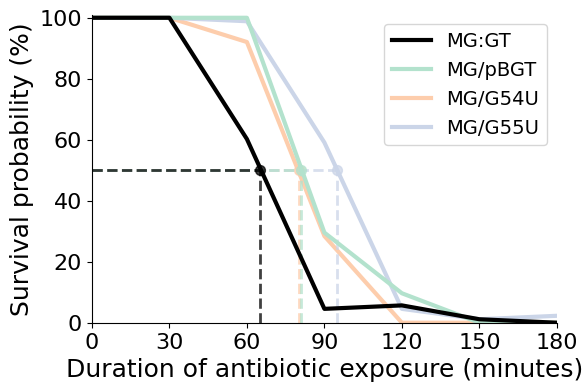

In [20]:
# IMPORT DATA
file_name = 'strains_survival_prob.csv'
df = pd.read_csv(data_pathD + file_name, skiprows=1, header=None)

delta_T = 60 * np.array(df.iloc[:,0])
MG_surv = 100 * np.array(df.iloc[:,1])
pBGT_surv = 100 * np.array(df.iloc[:,2])
G54U_surv = 100 * np.array(df.iloc[:,3])
G55U_surv = 100 * np.array(df.iloc[:,4])

# SET COLORS
colors = sns.color_palette('Pastel2', n_colors=4)
color_MG = (0, 0, 0)
color_pBGT = colors[0]
color_G54U = colors[1]
color_G55U = colors[2]

plot_data=[MG_surv,pBGT_surv,G54U_surv,G55U_surv]
plot_colors=[color_MG,color_pBGT,color_G54U,color_G55U]
plot_names=[ 'MG:GT','MG/pBGT', 'MG/G54U', 'MG/G55U']
zorders=[3,2,1,1]
xnew = np.linspace(0, 180,181)

strain_t50_dict=dict.fromkeys(plot_names)

# PLOT FIGURE
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update({'font.size': 18})
fig.set_facecolor('white')

for i,this_surv in enumerate(plot_data):
    ax.plot(delta_T, this_surv, '-', color=plot_colors[i], linewidth=3,label=plot_names[i],zorder=zorders[i])

    f2 = interpolate.interp1d(delta_T, this_surv, kind = 'linear')
    nys=f2(xnew).round()
    y50i=np.where((nys>=49)&(nys<=51))[0][0]
    strain_t50_dict[plot_names[i]]=y50i
    ax.scatter(y50i,50,color=plot_colors[i],s=50,alpha=.75,zorder=zorders[i])
    ax.vlines(x=y50i,ymin=0,ymax=50,color=plot_colors[i],ls="--",lw=2,alpha=.75,zorder=zorders[i])
    ax.hlines(y=50,xmin=0,xmax=y50i,color=plot_colors[i],ls="--",lw=2,alpha=.75,zorder=zorders[i])


ax.set_ylim([0, 101])
ax.set_xlim([0, delta_T[-1]])
ax.set_xticks(np.arange(0, 181, 30))
ax.set_xlabel('Duration of antibiotic exposure (minutes)', fontsize=18)
ax.set_ylabel('Survival probability (%)', fontsize=18)
ax.legend( fontsize=14, loc='upper right')
ax.tick_params(labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_legend().legendHandles[3].set_color('black')
#plt.tight_layout()
plt.savefig(fig_path+'Fig-3D.pdf', bbox_inches='tight')
plt.show()


In [21]:
strain_t50_dict

{'MG:GT': 65, 'MG/pBGT': 81, 'MG/G54U': 80, 'MG/G55U': 95}